In [2]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
from scipy import constants
import os, sys
from astropy.io import ascii
import astropy.constants
from cmcrameri import cm

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner
import seaborn as sns

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
scripts_path = "scripts" #os.path.join(repo_root, 'scripts')
sys.path.append(scripts_path)

import prior_funcs, utils
from pitchfork_funcs import emulator
from pitchfork_funcs import nested_sampler

2025-02-26 13:11:44.181471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-26 13:11:44.192642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-26 13:11:44.196025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 13:11:44.741229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
def evidence_heatmap(X,Y,C, fig, ax, xlabel=None, ylabel=None, clabel=None, cmap=cm.lajolla):
    C_array = np.zeros((len(Y), len(X)))
    y_i = len(Y)-1
    c_i = 0
    
    for y in Y:
        x_i=0
        for x in X:
            C_array[y_i, x_i] = C[c_i]
            
            x_i += 1
            c_i +=1

        y_i -= 1
    
    im = ax.imshow(C_array, cmap = cmap)
    fig.colorbar(im, label=clabel)
    ax.grid(False)
    ax.set_xticks(np.arange(len(L)), labels=L)
    ax.set_yticks(np.arange(len(S)), labels=S[::-1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def prior_heatmap(X_prior, Y_prior, fig, ax, samples =5000, cmap=cm.lajolla):
    Y_prior_samples =  Y_prior.rvs(5000)
    X_prior_samples =  X_prior.rvs(5000)
    
    sns.kdeplot(x=X_prior_samples, y=Y_prior_samples, fill=True, cmap=cmap, cbar=True, thresh=0, levels=100, cbar_kws={'label':'P'}, ax=ax)
    ax.set_xlim(2,18)
    ax.set_ylim(0,76)
    ax.set_xlabel(r'$L / \Delta\nu$')
    ax.set_ylabel(r'$\sigma$, $\mu Hz^{2}$')



def posterior_heatmap(X, X_prior, Y, Y_prior, C, fig, ax, xlabel=None, ylabel=None, clabel=None, cmap=cm.lajolla):
    C_array = np.zeros((len(Y), len(X)))
    y_i = len(Y)-1
    c_i = 0

    C=np.array(C)

    for y in Y:

        y_posterior = Y_prior.pdf(y)
        x_i=0
        for x in X:
            x_posterior = X_prior.pdf(x)

            xy_posterior = x_posterior * y_posterior

            C_norm = (C[c_i]-C.min())/(C.max()-C.min())
            C_array[y_i, x_i] = C_norm * xy_posterior
            
            x_i += 1
            c_i +=1

        y_i -= 1

    im = ax.imshow(C_array, cmap = cmap)
    fig.colorbar(im, label=clabel)
    ax.grid(False)
    ax.set_xticks(np.arange(len(L)), labels=L)
    ax.set_yticks(np.arange(len(S)), labels=S[::-1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)


    optimal_C = C_array.max()
    optimal_gp_idxs = np.where(C_array==optimal_C)

    optimal_L = L[optimal_gp_idxs[1][0]]
    optimal_S = S[len(S)-1 - optimal_gp_idxs[0][0]]

    ax.scatter(optimal_gp_idxs[1][0], optimal_gp_idxs[0][0],s=80, marker='s',facecolors='none', edgecolors='r')

    return [optimal_L, optimal_S]

    

Text(0.5, 0, '$\\sigma$, $\\mu$Hz$^2$')

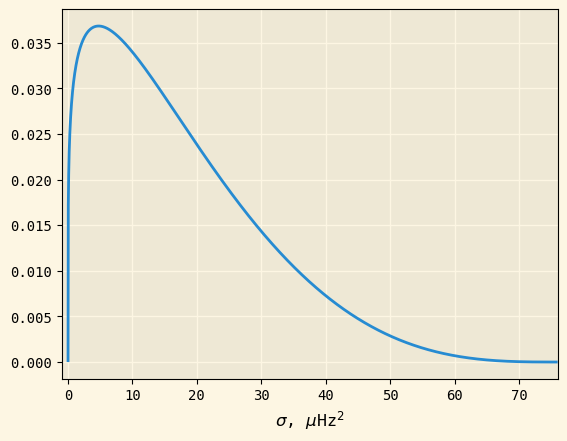

In [11]:
S_prior = scipy.stats.beta(loc=0,scale=76, a=1.2, b=4)
#S_prior = scipy.stats.beta(loc=0,scale=76, a=1, b=1)
L_prior = scipy.stats.beta(loc=0,scale=19, a=1, b=1)
x=np.linspace(0,200,10000)

fig, ax = plt.subplots()

ax.plot(x, S_prior.pdf(x))
ax.set_xlim(-1, 76)

ax.set_xlabel(r"$\sigma$, $\mu$Hz$^2$")

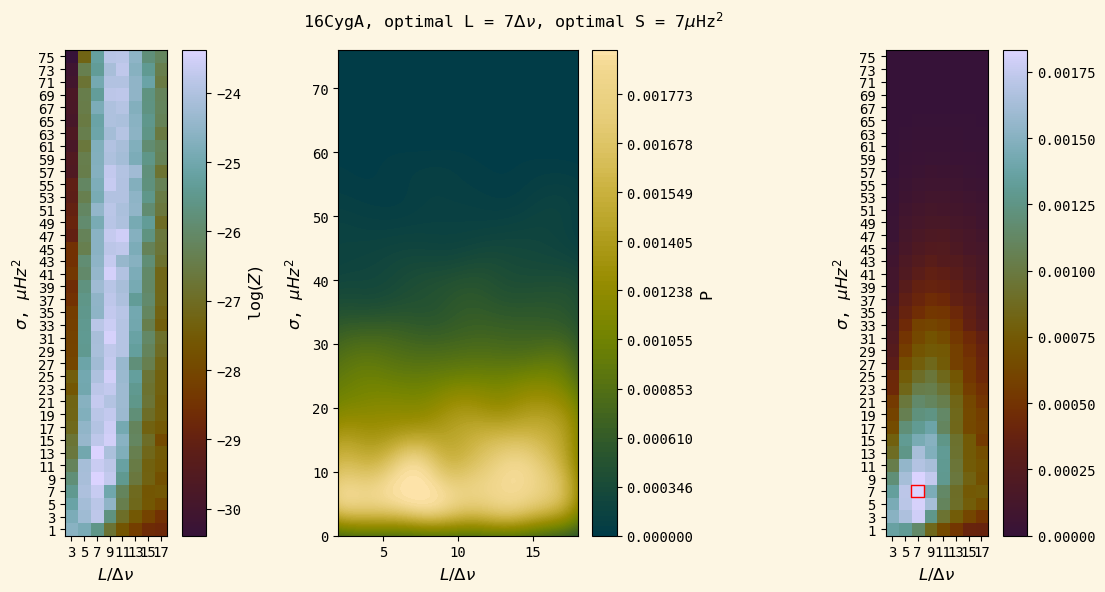

In [34]:
star_name = '16CygA'

samples_path = f'stars/{star_name}/gp-test'

logz_list = []
logzerr_list = []

L = [(l*2) + 1 for l in range(1,9)]
S = [(s*2) + 1 for s in range(38)]

for s in S:
    for l in L:
        with open(samples_path+f'/samples_s{s}_l{l}.pkl', 'rb') as fp:
            samples = pickle.load(fp)
        logz_list.append(samples['logz'])
        logzerr_list.append(samples['logzerr'])

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,6))

evidence_heatmap(L, S, logz_list, fig, ax1, cmap=cm.glasgow, xlabel=r'$L / \Delta\nu$' , ylabel= r'$\sigma$, $\mu Hz^{2}$' , clabel=r'log$(Z)$')

prior_heatmap(L_prior, S_prior, fig, ax2, cmap=cm.bamako,samples=10000)

optimal_L, optimal_S = posterior_heatmap(L, L_prior, S, S_prior,  logz_list, 
                                         fig, ax3, cmap=cm.glasgow, xlabel=r'$L / \Delta\nu$' , ylabel= r'$\sigma$, $\mu Hz^{2}$')

plt.suptitle(rf"{star_name}, optimal L = {optimal_L}$\Delta \nu$, optimal S = {optimal_S}$\mu$Hz$^2$")
plt.tight_layout()

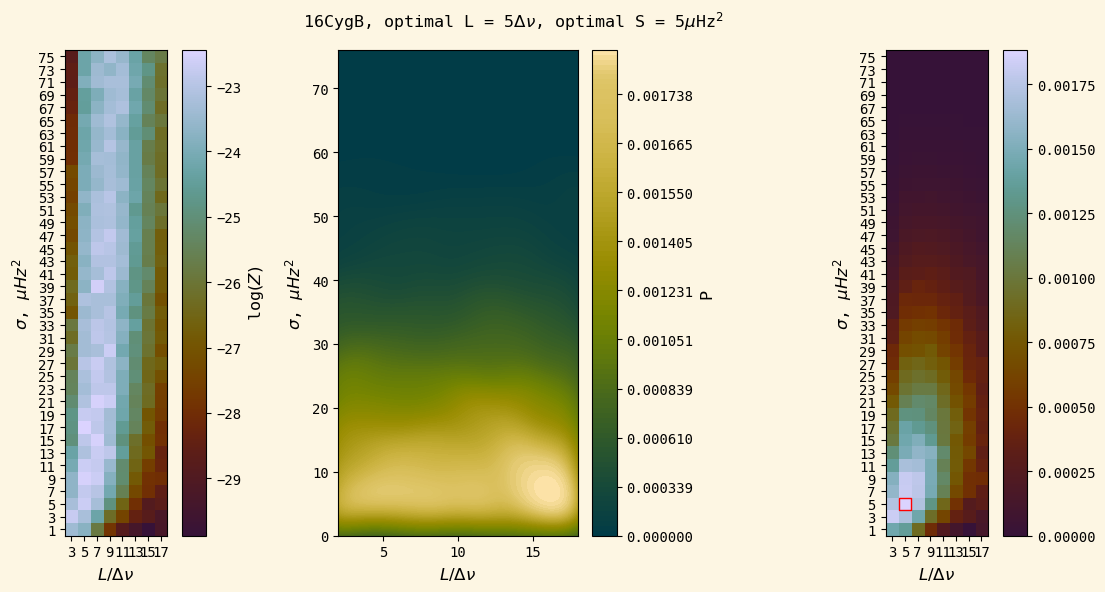

In [35]:
star_name = '16CygB'

samples_path = f'stars/{star_name}/gp-test'

logz_list = []
logzerr_list = []

L = [(l*2) + 1 for l in range(1,9)]
S = [(s*2) + 1 for s in range(38)]

for s in S:
    for l in L:
        with open(samples_path+f'/samples_s{s}_l{l}.pkl', 'rb') as fp:
            samples = pickle.load(fp)
        logz_list.append(samples['logz'])
        logzerr_list.append(samples['logzerr'])

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,6))

evidence_heatmap(L, S, logz_list, fig, ax1, cmap=cm.glasgow, xlabel=r'$L / \Delta\nu$' , ylabel= r'$\sigma$, $\mu Hz^{2}$' , clabel=r'log$(Z)$')

prior_heatmap(L_prior, S_prior, fig, ax2, cmap=cm.bamako,samples=10000)

optimal_L, optimal_S = posterior_heatmap(L, L_prior, S, S_prior,  logz_list, 
                                         fig, ax3, cmap=cm.glasgow, xlabel=r'$L / \Delta\nu$' , ylabel= r'$\sigma$, $\mu Hz^{2}$')

plt.suptitle(rf"{star_name}, optimal L = {optimal_L}$\Delta \nu$, optimal S = {optimal_S}$\mu$Hz$^2$")
plt.tight_layout()

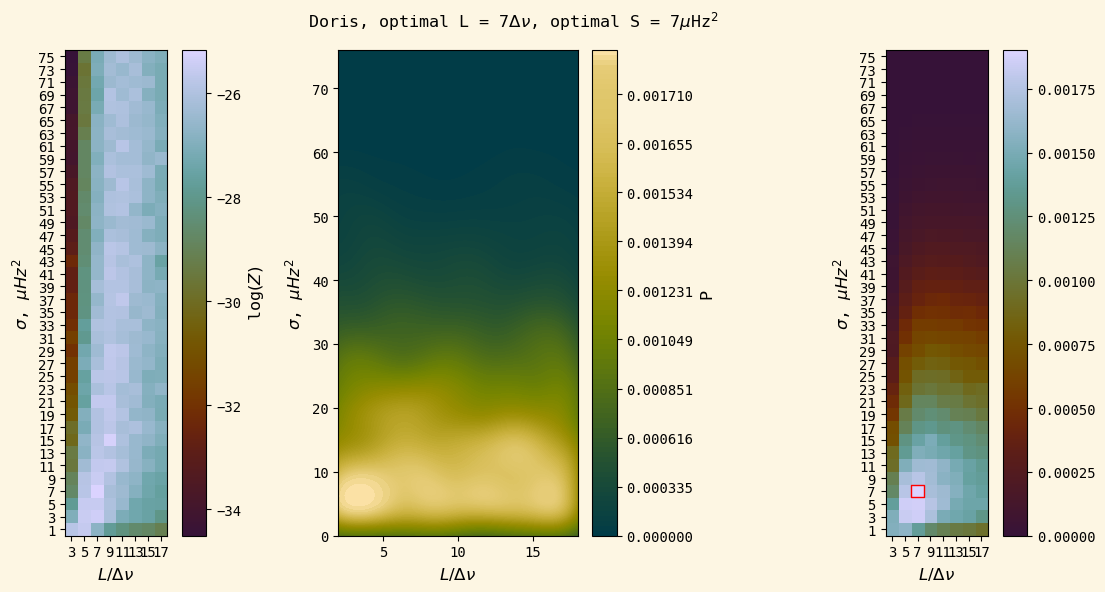

In [36]:
star_name = 'Doris'

samples_path = f'stars/{star_name}/gp-test'

logz_list = []
logzerr_list = []

L = [(l*2) + 1 for l in range(1,9)]
S = [(s*2) + 1 for s in range(38)]

for s in S:
    for l in L:
        with open(samples_path+f'/samples_s{s}_l{l}.pkl', 'rb') as fp:
            samples = pickle.load(fp)
        logz_list.append(samples['logz'])
        logzerr_list.append(samples['logzerr'])

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,6))

evidence_heatmap(L, S, logz_list, fig, ax1, cmap=cm.glasgow, xlabel=r'$L / \Delta\nu$' , ylabel= r'$\sigma$, $\mu Hz^{2}$' , clabel=r'log$(Z)$')

prior_heatmap(L_prior, S_prior, fig, ax2, cmap=cm.bamako,samples=10000)

optimal_L, optimal_S = posterior_heatmap(L, L_prior, S, S_prior,  logz_list, 
                                         fig, ax3, cmap=cm.glasgow, xlabel=r'$L / \Delta\nu$' , ylabel= r'$\sigma$, $\mu Hz^{2}$')

plt.suptitle(rf"{star_name}, optimal L = {optimal_L}$\Delta \nu$, optimal S = {optimal_S}$\mu$Hz$^2$")
plt.tight_layout()

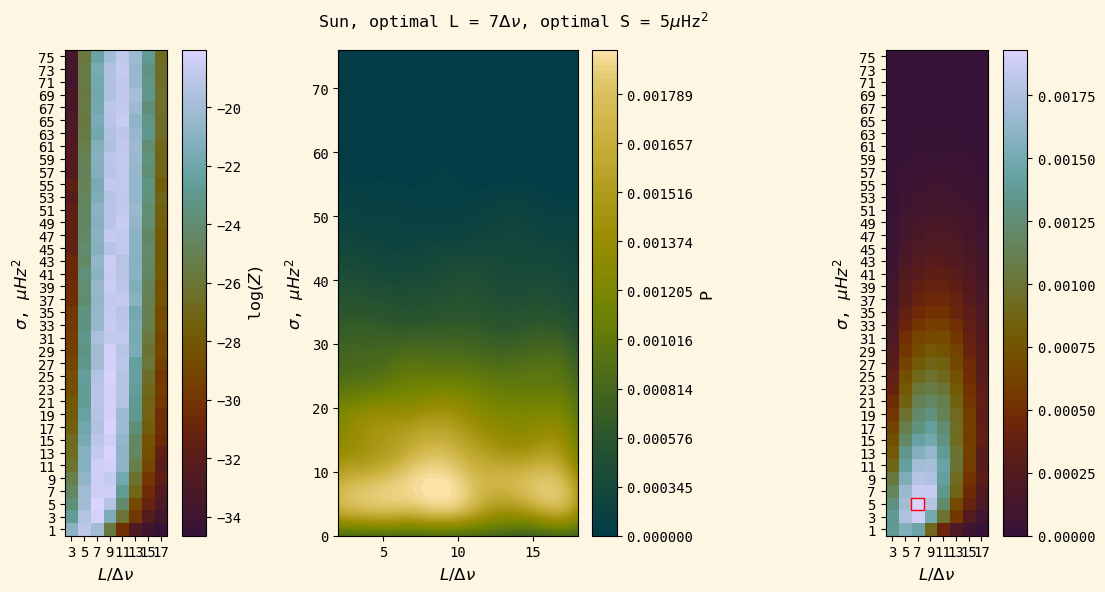

In [37]:
star_name = 'Sun'

samples_path = f'stars/{star_name}/gp-test'

logz_list = []
logzerr_list = []

L = [(l*2) + 1 for l in range(1,9)]
S = [(s*2) + 1 for s in range(38)]

for s in S:
    for l in L:
        with open(samples_path+f'/samples_s{s}_l{l}.pkl', 'rb') as fp:
            samples = pickle.load(fp)
        logz_list.append(samples['logz'])
        logzerr_list.append(samples['logzerr'])

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,6))

evidence_heatmap(L, S, logz_list, fig, ax1, cmap=cm.glasgow, xlabel=r'$L / \Delta\nu$' , ylabel= r'$\sigma$, $\mu Hz^{2}$' , clabel=r'log$(Z)$')

prior_heatmap(L_prior, S_prior, fig, ax2, cmap=cm.bamako,samples=10000)

optimal_L, optimal_S = posterior_heatmap(L, L_prior, S, S_prior,  logz_list, 
                                         fig, ax3, cmap=cm.glasgow, xlabel=r'$L / \Delta\nu$' , ylabel= r'$\sigma$, $\mu Hz^{2}$')

plt.suptitle(rf"{star_name}, optimal L = {optimal_L}$\Delta \nu$, optimal S = {optimal_S}$\mu$Hz$^2$")
plt.tight_layout()

<ErrorbarContainer object of 3 artists>

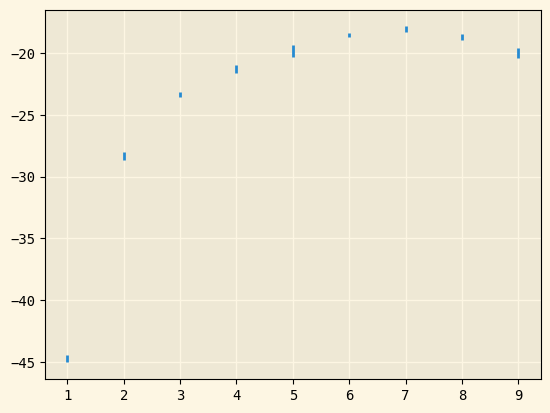

In [9]:
star_name = 'Sun'

samples_path = f'stars/{star_name}/gp-test3'

logz_list = []
logzerr_list = []

L = [1,2,3,4,5,6,7,8,9]
S = [4]

for s in S:
    for l in L:
        with open(samples_path+f'/samples_s{s}_l{l}.pkl', 'rb') as fp:
            samples = pickle.load(fp)
        logz_list.append(samples['logz'])
        logzerr_list.append(samples['logzerr'])

fig, ax = plt.subplots()

ax.errorbar(L, logz_list, yerr=logzerr_list, linestyle='')


[-36.647588938305404, -26.115257814512272, -25.331425212137862, -24.238623506215713, -23.86963876645804, -23.6991096746291, -23.838647361091997, -24.480346653531736, -25.25098069403176]


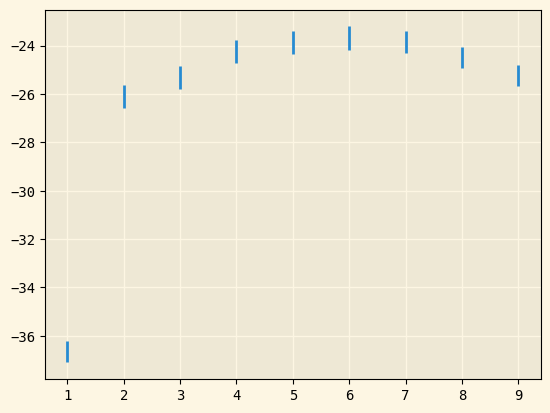

In [2]:
star_name = '16Cyg/16CygA'

samples_path = f'stars/{star_name}/gp-test3'

logz_list = []
logzerr_list = []

L = [1,2,3,4,5,6,7,8,9]
S = [4]

for s in S:
    for l in L:
        with open(samples_path+f'/samples_s{s}_l{l}.pkl', 'rb') as fp:
            samples = pickle.load(fp)
        logz_list.append(samples['logz'])
        logzerr_list.append(samples['logzerr'])

fig, ax = plt.subplots()

ax.errorbar(L, logz_list, yerr=logzerr_list, linestyle='')

print(logz_list)


[-34.37131185538355, -25.21426961284698, -22.714657955955, -22.635337135055543, -22.496632686842613, -22.87296628562115, -23.040390615959346, -23.63000293779313, -24.698527198590284]


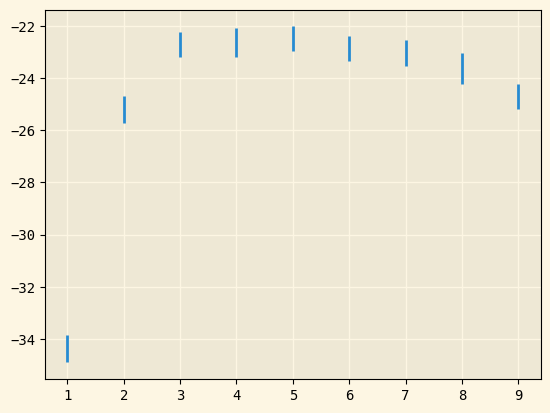

In [3]:
star_name = '16Cyg/16CygB'

samples_path = f'stars/{star_name}/gp-test3'

logz_list = []
logzerr_list = []

L = [1,2,3,4,5,6,7,8,9]
S = [4]

for s in S:
    for l in L:
        with open(samples_path+f'/samples_s{s}_l{l}.pkl', 'rb') as fp:
            samples = pickle.load(fp)
        logz_list.append(samples['logz'])
        logzerr_list.append(samples['logzerr'])

fig, ax = plt.subplots()

ax.errorbar(L, logz_list, yerr=logzerr_list, linestyle='')

print(logz_list)


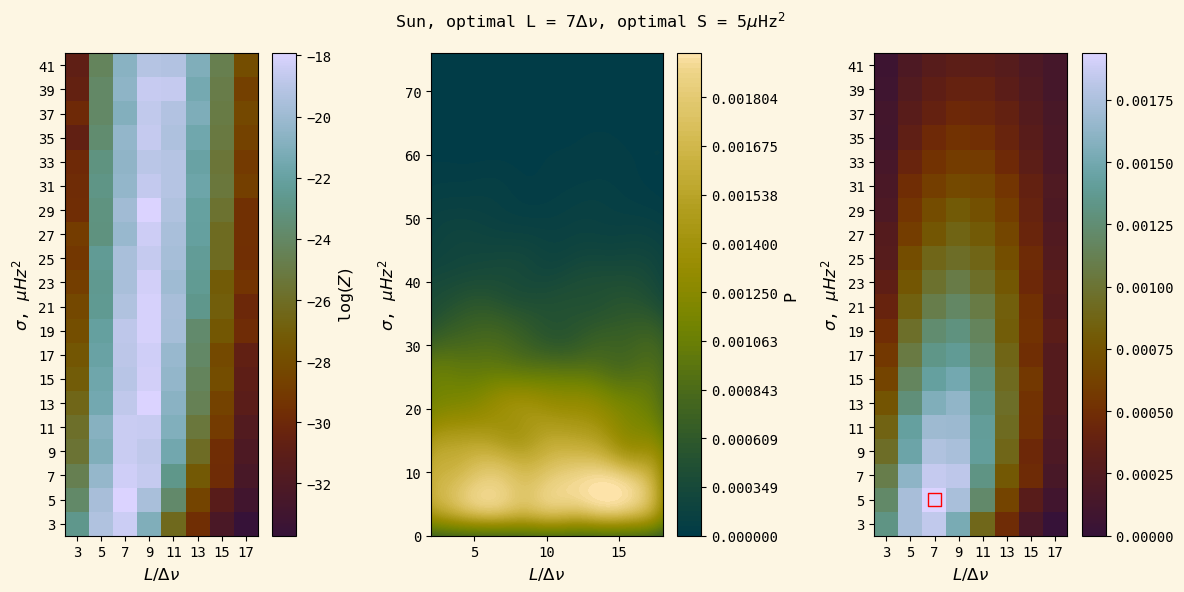

In [13]:
star_name = 'Sun'

samples_path = f'stars/{star_name}/gp-test2'

logz_list = []
logzerr_list = []

L = [(l*2) + 1 for l in range(1,9)]
S = [(s*2) + 1 for s in range(1,21)]

for s in S:
    for l in L:
        with open(samples_path+f'/samples_s{s}_l{l}.pkl', 'rb') as fp:
            samples = pickle.load(fp)
        logz_list.append(samples['logz'])
        logzerr_list.append(samples['logzerr'])

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,6))

evidence_heatmap(L, S, logz_list, fig, ax1, cmap=cm.glasgow, xlabel=r'$L / \Delta\nu$' , ylabel= r'$\sigma$, $\mu Hz^{2}$' , clabel=r'log$(Z)$')

prior_heatmap(L_prior, S_prior, fig, ax2, cmap=cm.bamako,samples=10000)

optimal_L, optimal_S = posterior_heatmap(L, L_prior, S, S_prior,  logz_list, 
                                         fig, ax3, cmap=cm.glasgow, xlabel=r'$L / \Delta\nu$' , ylabel= r'$\sigma$, $\mu Hz^{2}$')

plt.suptitle(rf"{star_name}, optimal L = {optimal_L}$\Delta \nu$, optimal S = {optimal_S}$\mu$Hz$^2$")
plt.tight_layout()